In [1]:
from utils import *
import tensorflow as tf
from keras.optimizers import Adam
from keras import utils

In [2]:
df_dict , max_rows, num_features = read_conv(train=True)
features, depression_labels, gender_labels = prep_conv_data(df_dict, max_rows, num_features)

Removing null values present in spk_402.csv


In [3]:
# define and train CNN Model
utils.set_random_seed(3)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), padding = "same",use_bias = True,strides = (1,1), activation='relu',
                           input_shape=(378, 88, 1)),
    
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, (2, 2),  padding = "same",use_bias = True,strides = (1,1),activation='relu'),
  
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    
    # tf.keras.layers.Conv2D(4, (2, 2), activation='relu', padding = "same",strides = (1,1),
    #                        kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 378, 88, 32)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 189, 44, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 189, 44, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 44, 32)       4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 94, 22, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 94, 22, 32)        0

In [4]:
unique_classes, class_counts = np.unique(depression_labels, return_counts=True)
total_samples = depression_labels.shape[0]
class_weights = {}

for class_label, class_count in zip(unique_classes, class_counts):
    class_weight = total_samples / (2.0 * class_count)
    class_weights[class_label] = class_weight

In [5]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=5)
history = model.fit(features, depression_labels, epochs=50, batch_size=1, 
                    callbacks=[callback],
                    validation_split=0.15,
                    class_weight=class_weights)

Epoch 1/50
73/73 [==============================] - 1s 15ms/step - loss: 863.6146 - accuracy: 0.5479 - val_loss: 6.3036 - val_accuracy: 0.8571
Epoch 2/50
73/73 [==============================] - 1s 15ms/step - loss: 25.5565 - accuracy: 0.5616 - val_loss: 1.6036 - val_accuracy: 0.3571
Epoch 3/50
73/73 [==============================] - 1s 15ms/step - loss: 2.2895 - accuracy: 0.8356 - val_loss: 0.4408 - val_accuracy: 0.8571
Epoch 4/50
73/73 [==============================] - 1s 15ms/step - loss: 1.7927 - accuracy: 0.7945 - val_loss: 0.4582 - val_accuracy: 0.8571
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 0.4558 - accuracy: 0.9315 - val_loss: 0.7504 - val_accuracy: 0.7857
Epoch 6/50
73/73 [==============================] - 1s 16ms/step - loss: 0.1830 - accuracy: 0.9726 - val_loss: 0.6386 - val_accuracy: 0.7857
Epoch 7/50
73/73 [==============================] - 1s 15ms/step - loss: 0.0261 - accuracy: 0.9863 - val_loss: 0.6340 - val_accuracy: 0.7857
Epoch 8/50

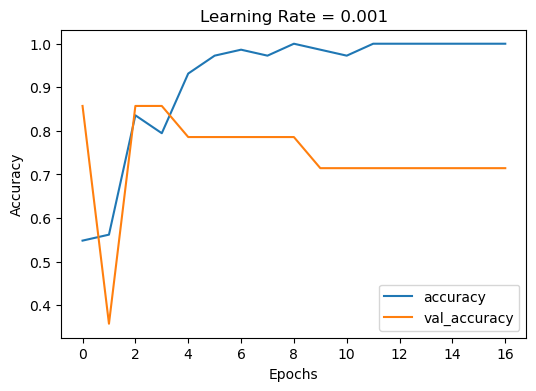

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
test_df_dict , _, _ = read_conv(train=False)
test_features, test_depression_labels, test_gender_labels = prep_conv_data(test_df_dict, max_rows, num_features)

In [8]:
test_loss, test_acc = model.evaluate(test_features,  test_depression_labels)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

1/1 [==============================] - 0s 97ms/step - loss: 2.5440 - accuracy: 0.6000
Test loss:  2.5440163612365723
Test accuracy:  0.6000000238418579


In [9]:
PATH_TEST = "../processed_data/cleaned_data/clean_test_data.csv"
test_df = pd.read_csv(PATH_TEST)
y_test = test_df[["Participant_ID", "Depression", "Gender"]]
y_test = y_test.groupby("Participant_ID").agg({"Depression":"max", "Gender":"max"}).reset_index()
y_test.head()

,Participant_ID,Depression,Gender
0,305,0,1
1,312,0,1
2,315,0,1
3,320,1,0
4,321,1,0


In [10]:
y_test["Depression_predicted"] = model.predict(test_features)

1/1 [==============================] - 0s 57ms/step


In [11]:
y_test['Depression_predicted'] = np.where(y_test['Depression_predicted']>=0.5, 1, 0)

Recall Male: 0.0
Recall Female: 0.2
Accuracy: 0.7
Balanced Accuracy: 0.5476190476190477
Equality of Opportunity: 0.8


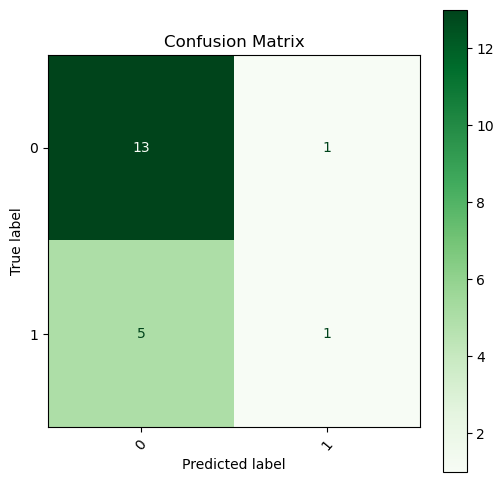

In [12]:
# Aggregate target and predicted labels at participant level for male participants
y_male = y_test[y_test['Gender'] == 1]
# Aggregate target and predicted labels at participant level for female participants
y_female = y_test[y_test['Gender'] == 0]
# Compute recall/tpr for male and female classification
tpr_male = recall_score(y_male['Depression'], y_male['Depression_predicted'])
tpr_female = recall_score(y_female['Depression'], y_female['Depression_predicted'])

# Compute metrics
accuracy = accuracy_score(y_test['Depression'], y_test['Depression_predicted'])
bal_accuracy = balanced_accuracy_score(y_test['Depression'], y_test['Depression_predicted'])

# Compute Equality of opportunity score
print("Recall Male:", tpr_male)
print("Recall Female:", tpr_female)
print(f"Accuracy: {accuracy}")
print(f"Balanced Accuracy: {bal_accuracy}")
print(f"Equality of Opportunity: {1-abs(tpr_male-tpr_female)}")
conf_matrix = confusion_matrix(y_test['Depression'], y_test['Depression_predicted'])
#Visualizing the confusion matrix
plt.rcParams['figure.figsize'] = (6, 6)
display_c_m = ConfusionMatrixDisplay(conf_matrix)
display_c_m.plot(cmap='Greens', xticks_rotation=50)
plt.title('Confusion Matrix')
plt.show()